# Kalman Filter

The localization of the Thymio robot is performed using a Kalman filter. This filtering method is well suited to estimating the position and orientation of a mobile robot from noisy or incomplete measurements. The design of the filter in this project is based on using the position ($x, y$) and orientation ($\theta$) provided by the camera as measurements. In addition, the speed of the robot, provided by the wheel speed sensors ($v_r, v_l$), is used as a prediction. In short, the Kalman filter merges a prediction of the system's future state with a measurement of that state to estimate position probabilistically.

## State-space model

### Prediction

To estimate the robot's future position, a state-space model needs to be developed: 

$$\hat{s}_{a\_priori}^{t+1} = A \cdot \hat{s}_{a\_posteriori}^{t} + B \cdot u^{t} + q^t$$

The prediction of the future state is referred to as $\hat{s}_{a\_priori}^{t+1}$, i.e. the a priori estimate at time t+1. Since the state of the system is defined by its position ($x, y$) and orientation ($\theta$), this gives: 

$$\hat{s}_{a\_priori}^{t+1} = \begin{pmatrix}
\hat{x}_{a\_priori}^{t+1} \\\\
\hat{y}_{a\_priori}^{t+1} \\\\
\hat{\theta}_{a\_priori}^{t+1}
\end{pmatrix}$$

The current state corresponds to the term $\hat{s}_{a\_posteriori}^{t}$, which is the a posteriori estimate at time t. In the same way as above, this gives:

$$\hat{s}_{a\_posteriori}^{t} = \begin{pmatrix}
\hat{x}_{a\_posteriori}^{t} \\\\
\hat{y}_{a\_posteriori}^{t} \\\\
\hat{\theta}_{a\_posteriori}^{t}
\end{pmatrix}$$

The system input at time t is represented by the vector $u^{t}$. This is made up of two terms: translational speed ($v$) and rotational speed ($\omega$). 

$$u^t = \begin{pmatrix}
v \\\\
\omega
\end{pmatrix} $$

These are defined on the basis of the speeds measured by the wheel speed sensors, i.e. the right ($v_r$) and left ($v_l$) speeds, and the spacing between the two wheels ($e$).

$$ v = \cfrac{v_r + v_l}{2} \qquad\qquad \omega = \cfrac{v_r-v_l}{e} $$ 

Matrix A characterizes the evolution of the system state, while matrix B describes the impact of the input on the future state. An odometry-based approach allows us to determine these two matrices by considering a very short time interval ($\delta t$). During this time interval, the robot rotates by $\delta \theta = \omega \cdot \delta t$. Knowing this, and referring to the diagram below, the following system of equations can be established: 

$$\begin{equation}
\begin{cases}
\hat{x}_{a\_priori}^{t+1} = \hat{x}_{a\_posteriori}^{t} + v \cdot \cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{y}_{a\_priori}^{t+1} = \hat{y}_{a\_posteriori}^{t} + v \cdot \sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{\theta}_{a\_priori}^{t+1} = \hat{\theta}_{a\_posteriori}^{t} + \omega \cdot \delta t
\end{cases}
\end{equation}$$

![state-space_model](Images/schematics.png)

The matrix form of this system therefore becomes:

$$\begin{equation}
A = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}
\qquad\qquad
B = \begin{bmatrix} 
\cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0\\
\sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0 \\
0 & \delta t 
\end{bmatrix}
\end{equation}$$

The final term $q^t$ of this state-space model represents the stochastic perturbation of the state with covariance matrix Q defined as follows:

$$
Q = \begin{bmatrix} 
q_1 & 0 & 0\\ 
0 & q_2 & 0 \\ 
0 & 0 & q_3
\end{bmatrix}
$$

These diagonal coefficients can be evaluated using an approach similar to that used in Exercise 8 of the MICRO-452 course.  

### Measurement

Having explored the prediction phase of the state-space model, attention now turns to the second essential part: updating the measurements. This stage aims to refine the predictions by integrating real information captured by the camera. The formula governing this step is :

$$ m^{t+1} = C \cdot s^{t+1} + r^{t+1}$$ 

Measurements taken at time t+1 are represented here by the term $m_{t+1}$. The data collected by the camera are therefore:

$$m^{t+1} = \begin{pmatrix}
x_{captured}^{t+1} \\\\
y_{captured}^{t+1} \\\\
\theta_{captured}^{t+1}
\end{pmatrix}$$

The robot's position ($x, y$) and orientation ($\theta$) measured by the camera are used directly as system outputs, without any transformation. The matrix C linking the measurements to the state is therefore defined as follows:

$$C = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}$$

The term $s^{t+1}$ simply represents the state of the system at time t+1:

$$s^{t+1} = \begin{pmatrix}
x^{t+1} \\\\
y^{t+1} \\\\
\theta^{t+1}
\end{pmatrix}$$

Finally, the last term $r^{t+1}$ of this equation represents noise on measurements with a covariance matrix R defined as follows:

$$
R = \begin{bmatrix} 
r_1 & 0 & 0\\ 
0 & r_2 & 0 \\ 
0 & 0 & r_3
\end{bmatrix}
$$

Note: When the camera's view is obstructed, estimation is only possible using the prediction model.

## Initialization

### Imports

In [1]:
import math
import time
import scipy
import asyncio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import randrange
from tdmclient import aw, ClientAsync

### Basic functions

In [2]:
# Thymio connection
async def connect_Thymio():
    """
    Establish a connection with the Thymio if possible
    """
    global node, client
    try:
        client = ClientAsync()
        node = await asyncio.wait_for(client.wait_for_node(), timeout=2.0)
        await node.lock()
        print("Thymio connected")

    except asyncio.TimeoutError:
        print("Thymio not connected: Timeout while waiting for node.")
    except Exception as e:
        print(f"Thymio not connected: {str(e)}")
        
# Thymio disconnection
def disconnect_Thymio():
    """
    Enable to disconnect the Thymio
    """
    aw(node.stop())
    aw(node.unlock())
    print("Thymio disconnected")

# Thymio control motor speeds  
def set_speeds(left_speed, right_speed):
    """
    Enable to set the speed of the Thymio's wheels
    """
    return {
        "motor.left.target": [left_speed],
        "motor.right.target": [right_speed],
    }
    
# Check
await connect_Thymio()
node.send_set_variables(set_speeds(40, 40))
time.sleep(2)
node.send_set_variables(set_speeds(0, 0))
disconnect_Thymio()

Thymio connected
Thymio disconnected


### Global variables

In [3]:
# General variables:
update_time = 0.05               # Time in [s] before the next update
thymio_speed_to_mms = 0.4348     # Ratio to convert Thymio speed into mm/s
acquire_data = True              # Boolean that determines whether the program should collect data or not
samples_acquired = 0             # Number of samples acquired
nb_samples = 10                  # Number of samples to reach
camera_on = False                # Boolean that determines whether the camera has vision or not

#Thymio variables: 
robot_diameter = 94              # Distance between the two wheels
v_r = 0                          # Speed of the right wheel 
v_l = 0                          # Speed of the left wheel
v_r_tot = 0                      # Sum of right speeds over several samples
v_l_tot = 0                      # Sum of left speeds over several samples
v = 0                            # Average translation speed
w = 0                            # Average rotation speed
delta_theta = 0                  # Angle variation
thymio_data = []

#Thymio position and orientation
x0_vision = 10
y0_vision = 10
theta0_vision = np.pi/2
x_vision = 20
y_vision = 20
theta_vision = np.pi

### Filter initialization

In [4]:
def filter_initialization():
    """
    Initialize the various vectors and matrices requiered for filtering
    
    param vision_x_position: robot x position deduced from the camera vision
    param vision_y_position: robot y position deduced from the camera vision
    param vision_theta_orientation: robot theta orientation deduced from the camera vision
    """
    
    global s_prev_est_a_posteriori, P_prev_est_a_posteriori, A, B, u, C, Q, R

    ## Previous State A Posteriori Estimation Vector
    # Vector representing the estimated state of the system at the previous time step
    s_prev_est_a_posteriori = np.array([[x0_vision], 
                                        [y0_vision], 
                                        [theta0_vision]])
    #print("\n".join([f"s_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))
    
    ## Previous State A Posteriori Covariance Matrix
    # Matrix representing the estimated precision of the previous estimated state
    P_prev_est_a_posteriori = np.array([[1000, 0, 0], 
                                        [0, 1000, 0], 
                                        [0, 0, 1000]]) 
    #print("\n".join([f"P_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in P_prev_est_a_posteriori]), "]"]))

    ## State Matrix
    # Matrix defining how the system evolves from one time step to the next
    A = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"A = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in A]), "]"]))
    
    ## Input Matrix 
    # Matrix describing the impact of the input on the state
    B = np.array([[1, 0], 
                  [0, 1], 
                  [0, 0]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))
    
    ## Input Vector
    # Vector representing control inputs applied to the system 
    u = np.array([[0], 
                  [0]])
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))

    ## Output Matrix
    # Matrix linking measurements to state
    C = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"C = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in C]), "]"]))
    
    ## Process Noise Covariance Matrix
    # Covariance matrix representing uncertainty in system dynamics
    Q = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 0.1]])
    #print("\n".join([f"Q = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in Q]), "]"]))

    ## Measurement Noise Covariance Matrix
    # Matrix representing uncertainty of camera measurements
    R = np.array([[0.1, 0, 0], 
                  [0, 0.1, 0], 
                  [0, 0, 0.01]])
    #print("\n".join([f"R = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in R]), "]"]))

# Check
#filter_initialization()

## Update

In [5]:
from threading import Timer

# Define a RepeatedTimer class that uses Python's threading module to create 
# a timer that executes a specific function at regular intervals

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [6]:
def get_data():
    global v_r, v_l, v_r_tot, v_l_tot, samples_acquired, thymio_data
    if samples_acquired<nb_samples:
        if samples_acquired == 0:
            thymio_data.clear() 
        thymio_data.append({"left_speed":node["motor.left.speed"],
                            "right_speed":node["motor.right.speed"]})
        v_r_tot += node["motor.right.speed"]
        v_l_tot += node["motor.left.speed"]
        samples_acquired += 1
        #print("sample number : ", samples_acquired)
        #print("Right = {}, Left = {}".format(node["motor.right.speed"], node["motor.left.speed"]))
    else:
        v_r = round(v_r_tot/nb_samples)
        v_l = round(v_l_tot/nb_samples)
        
async def get_speeds():
    global samples_acquired, v_r_tot, v_l_tot
    if acquire_data:
        await node.wait_for_variables() # wait for Thymio variables values
        rt = RepeatedTimer(update_time, get_data) # Auto-start get_data()

        try:
            await client.sleep(1.5*((nb_samples)*update_time)) # Time needed for the sampling (with a safety constant)
        finally:
            rt.stop()  
            samples_acquired = 0
            v_r_tot = 0
            v_l_tot = 0

### Updating input vector and matrix

In [7]:
def update_input():
    """
    Update the input vector and matrix
    """
    
    global B,u
    
    print("v_r :", v_r)
    print("v_l :", v_l)
    
    # Average translational speed
    v = (v_r +v_l)/2 
    print("v : ", v)
    
    # Average rotational speed
    w = (v_r -v_l)/robot_diameter 
    
    # Input vector
    u = np.array([[v], 
                  [w]]) 
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))
    
    # Angle variation
    delta_theta = w * update_time
    
    # Input matrix
    B = np.array([[np.cos(delta_theta + s_prev_est_a_posteriori[2][0])*update_time, 0],
                  [np.sin(delta_theta + s_prev_est_a_posteriori[2][0])*update_time, 0], 
                  [0, update_time]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))

# Check
#update_input()

## Plot the speed graph

In [8]:
def speeds_graph():

    l_speed = [x["left_speed"] for x in thymio_data]
    r_speed = [x["right_speed"] for x in thymio_data]
    avg_speed = np.array([(x["left_speed"]+x["right_speed"])/2 for x in thymio_data])
    #print(avg_speed)

    # Print the speeds
    plt.plot(l_speed, label="Left motor")
    plt.plot(r_speed, label="Right motor")
    plt.plot(avg_speed, label="Average")
    plt.xlabel("Time step")
    plt.ylabel("Measured Velocity")
    plt.legend()
    plt.show()
    
    ########### Might be useful for the variance calculation ###########
    #                                                                  #
    # avg_speed = avg_speed[:] / thymio_speed_to_mms                   #
    # print(avg_speed)                                                 #
    #                                                                  #
    # var_speed = np.var(avg_speed)                                    #
    # print("The speed variance in mm^2/s^2 is {}".format(var_speed))  #
    #                                                                  #
    # q_nu = var_speed/2 # variance on speed state                     #
    # r_nu = var_speed/2 # variance on speed measurement               #
    # print("q_nu = {} et r_nu = {}".format(q_nu, r_nu))               #
    #                                                                  #
    # qp = 0.04 # variance on position state                           #
    # rp = 0.25 # variance on position measurement                     #
    #                                                                  #
    # qt = 0.04 # variance on orientation state                        #
    # rt = 0.25 # variance on orientation measurement                  #
    #                                                                  #
    ####################################################################

## Filtering

In [10]:
def kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori):
    """
    Estimates the current state using the input sensor data and the previous state
    
    param s_prev_est_a_posteriori: previous state a posteriori estimation
    param P_prev_est_a_posteriori: previous state a posteriori covariance
    
    return s_est_a_posteriori: new a posteriori state estimation
    return P_est_a_posteriori: new a posteriori state covariance
    """
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    s_est_a_priori = np.dot(A, s_prev_est_a_posteriori)+ np.dot(B, u);
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_prev_est_a_posteriori, A.T)) + Q
    
    ## Update         
    # m, C, and R for a posteriori estimate, depending on the detection of the camera
    if camera_on == True:
        m = np.array([[x_vision], 
                      [y_vision], 
                      [theta_vision]])
        # innovation / measurement residual
        i = m - np.dot(C, s_est_a_priori);
        # measurement prediction covariance
        S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R;     
        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S)));
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori + np.dot(K,i);
        P_est_a_posteriori = P_est_a_priori - np.dot(K,np.dot(C, P_est_a_priori));
    else:
        K = 0 # Kalman gain is null because the camera can't deliver any data
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori;
        P_est_a_posteriori = P_est_a_priori;
     
    return s_est_a_posteriori, P_est_a_posteriori

#Check
#kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)

## Testing

Thymio connected
Initial state = [
     10.00
     10.00
      1.57
]
v_r : 195
v_l : 191
v :  193.0


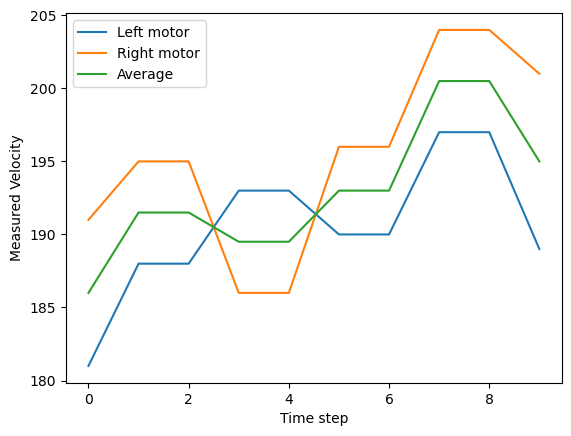

Next state = [
      9.98
     19.65
      1.57
]
v_r : 202
v_l : 194
v :  198.0


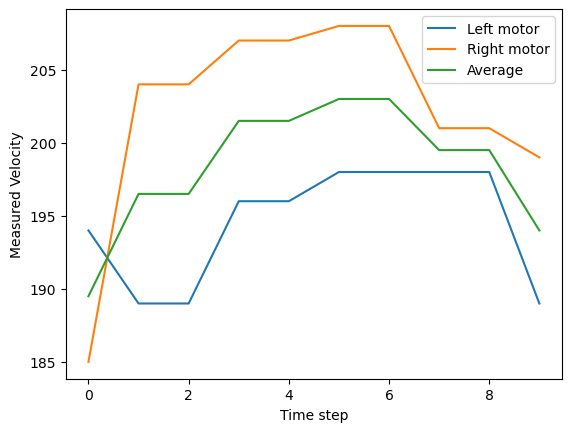

Next state = [
      9.92
     29.55
      1.58
]
v_r : 194
v_l : 197
v :  195.5


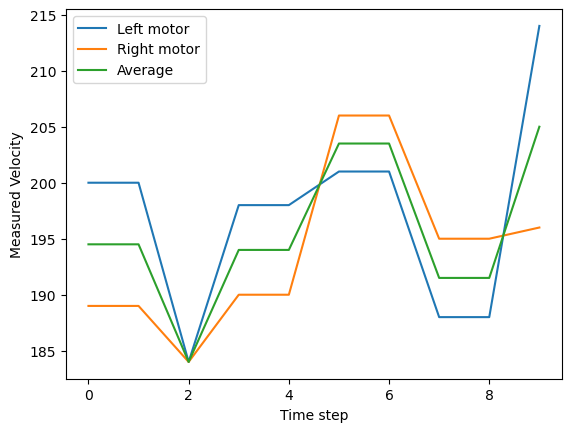

Next state = [
      9.87
     39.32
      1.58
]
Thymio disconnected


In [11]:
await connect_Thymio()

speed_test_value = randrange(200)      
    
node.send_set_variables(set_speeds(speed_test_value, speed_test_value))

time.sleep(0.5)

# Test

# Initialization
filter_initialization()

# Initial state
print("\n".join([f"Initial state = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))

for _ in range(3):
    await get_speeds()         # Get the speeds
    update_input()             # Update inputs
    speeds_graph()             # Plot the graph of the speeds
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    print("\n".join([f"Next state = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))

node.send_set_variables(set_speeds(0, 0))

disconnect_Thymio()

What need to be done with the Thymio used for the final demo:
- Evaluate the Q and R matrices
- Find the speed in pixels per second : $v_{px/s} = v_{thymio} \cdot thymio\_speed\_to\_mms \cdot mm\_to\_px$
- Time in the B matrix: update_time or 1.5*((nb_samples)*update_time)? Depends on how we decide to get the speed... 